In [1]:
import numpy as np 
import pandas as pd
import seaborn as sns

import datetime
import sys
import os 

from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import PowerTransformer, MinMaxScaler
from sklearn.pipeline import Pipeline, TransformerMixin
from sklearn.neighbors import LocalOutlierFactor
from scipy import stats  
from collections import Counter

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('bmh')

sys.path.append('..')
from src import config

if sys.platform == 'linux':
    path = config.LINUX_PATH
else:
    path = config.OS_PATH
os.chdir(path)

data_path = config.STRAVA_TRAIN_PATH
data = pd.read_csv(data_path, index_col=0)
print(data.columns.tolist())
data.head()

['name', 'distance', 'moving_time', 'total_elevation_gain', 'workout_type', 'timezone', 'achievement_count', 'kudos_count', 'manual', 'max_speed', 'average_heartrate', 'max_heartrate', 'pr_count', 'total_photo_count', 'suffer_score', 'GMT_date', 'GMT_time', 'local_date', 'local_time', 'datetime', 'year', 'weekofyear', 'month', 'dayofweek', 'weekend', 'hour', 'is_uk_awake', 'run_area', 'latlng_cluster', 'city', 'average_speed_mpk']


,name,distance,moving_time,total_elevation_gain,workout_type,timezone,achievement_count,kudos_count,manual,max_speed,...,weekofyear,month,dayofweek,weekend,hour,is_uk_awake,run_area,latlng_cluster,city,average_speed_mpk
287,🐅,10.4163,45.566667,18.0,0.0,America/Boise,1,29,False,5.0,...,11,3,2,0,15,1,5.428935,1,Boise,4.374278
288,🦏,16.1663,70.250000,20.0,0.0,America/Boise,5,36,False,5.3,...,11,3,2,0,8,1,16.859057,1,Boise,4.345763
289,💩,1.6812,8.166667,8.0,0.0,America/Boise,0,14,False,5.7,...,11,3,1,0,15,1,0.017541,1,Boise,4.857476
290,🦧,12.8514,42.183333,21.0,3.0,America/Boise,0,56,False,6.5,...,11,3,1,0,14,1,0.535336,1,Boise,3.282001
291,🆙,3.3194,15.300000,3.0,0.0,America/Boise,0,8,False,6.9,...,11,3,1,0,14,1,0.008149,1,Boise,4.608960


In [2]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 829 entries, 287 to 1165
Data columns (total 31 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   name                  829 non-null    object 
 1   distance              829 non-null    float64
 2   moving_time           829 non-null    float64
 3   total_elevation_gain  829 non-null    float64
 4   workout_type          798 non-null    float64
 5   timezone              829 non-null    object 
 6   achievement_count     829 non-null    int64  
 7   kudos_count           829 non-null    int64  
 8   manual                829 non-null    bool   
 9   max_speed             829 non-null    float64
 10  average_heartrate     804 non-null    float64
 11  max_heartrate         804 non-null    float64
 12  pr_count              829 non-null    int64  
 13  total_photo_count     829 non-null    int64  
 14  suffer_score          804 non-null    float64
 15  GMT_date            

In [3]:
numeric_cols = [
                'distance', 'moving_time', 'total_elevation_gain', 'max_speed',
                'average_heartrate', 'max_heartrate', 'pr_count', 'total_photo_count', 'suffer_score', 
                'run_area', 'average_speed_mpk', 'kudos_count'
                ]
cat_cols = [
            'workout_type', 'timezone', 'manual', 'year', 'weekofyear', 'month', 'dayofweek', 'weekend', 
            'hour', 'is_uk_awake', 'latlng_cluster', 'city'
            ]

Numeric and categorical columns 

In [4]:
# plot helper func
def plot_dist(data, col_name):
    print(data[col_name].describe())
    plt.figure(figsize=(9, 8))
    sns.displot(data[col_name], color='g', bins=100);

# Target variable

count    829.000000
mean      38.727382
std       24.900876
min        1.000000
25%       15.000000
50%       37.000000
75%       53.000000
max      171.000000
Name: kudos_count, dtype: float64


<Figure size 648x576 with 0 Axes>

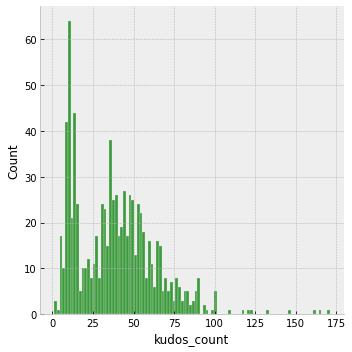

In [5]:
plot_dist(data, 'kudos_count')

With this information we can see that the kudos are skewed right (bimodal) and some outliers lies above ~100 (which we may want to consider removing before modeling). We would like to see more of a normal dist., so lets try using a BoxCox transform.

count    8.290000e+02
mean     9.823264e-17
std      1.000604e+00
min     -2.596586e+00
25%     -9.846625e-01
50%      1.387213e-01
75%      7.061644e-01
max      3.184915e+00
Name: target_boxcox, dtype: float64


<Figure size 648x576 with 0 Axes>

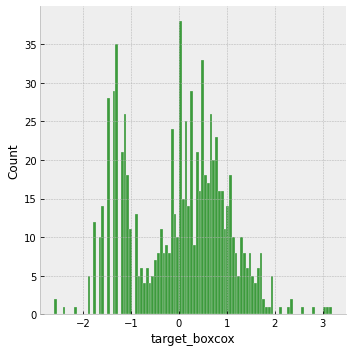

In [6]:
pt = PowerTransformer()
data.loc[:, 'target_boxcox'] = pt.fit_transform(data[['kudos_count']])
plot_dist(data, 'target_boxcox')

This looks more like a Gaussian curve. We need to sort outliers though. 

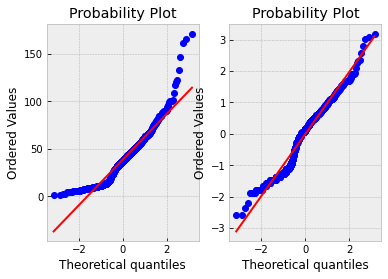

In [7]:
# pp-plots
plt.subplot(1, 2, 1)
res1 = stats.probplot(data['kudos_count'], plot=plt)
plt.subplot(1, 2, 2)
res = stats.probplot(data['target_boxcox'], plot=plt)
plt.show()

## Isolation Forest To Find Outliers

In [8]:
# training the model
outlier_model = IsolationForest(random_state=42)
cols = numeric_cols.copy()
data_train = data[cols].dropna()
outlier_model.fit(data_train)

# predictions
y_pred = outlier_model.predict(data_train)
from collections import Counter
Counter(y_pred)

Counter({1: 722, -1: 82})

In [9]:
data_train.loc[:, 'anomaly'] = outlier_model.predict(data_train)
data_train.head(20)

,distance,moving_time,total_elevation_gain,max_speed,average_heartrate,max_heartrate,pr_count,total_photo_count,suffer_score,run_area,average_speed_mpk,kudos_count,anomaly
287,10.4163,45.566667,18.0,5.0,130.3,149.0,0,0,10.0,5.428935,4.374278,29,1
288,16.1663,70.250000,20.0,5.3,141.9,158.0,3,0,25.0,16.859057,4.345763,36,1
289,1.6812,8.166667,8.0,5.7,139.2,150.0,0,0,2.0,0.017541,4.857476,14,1
290,12.8514,42.183333,21.0,6.5,146.3,191.0,0,0,24.0,0.535336,3.282001,56,1
291,3.3194,15.300000,3.0,6.9,113.3,126.0,0,0,2.0,0.008149,4.608960,8,1
292,8.1370,36.883333,9.0,4.8,128.4,155.0,0,0,8.0,0.490609,4.532499,34,1
293,8.0639,42.216667,52.0,9.1,127.8,153.0,0,0,9.0,0.047532,5.234296,35,1
294,16.1110,67.916667,201.9,5.4,147.0,163.0,2,0,40.0,0.601215,4.214972,57,1
295,8.1932,36.700000,11.0,6.7,131.3,142.0,0,0,8.0,6.094854,4.478904,48,1
296,27.6912,120.016667,282.1,6.6,154.3,172.0,2,0,128.0,107.926247,4.334460,77,-1


## IQR TO Find Outliers

In [10]:
outlier_model = LocalOutlierFactor(n_neighbors = 2, metric = "manhattan", contamination = 0.02)

cols = numeric_cols.copy()
data_train = data[cols].dropna()

y_pred = outlier_model.fit_predict(data_train)
print(Counter(y_pred))

Counter({1: 787, -1: 17})


In [11]:
outlier_index = np.where(y_pred == -1) # negative values are outliers and positives inliers
outlier_values = data_train.iloc[outlier_index] # filter outlier values
# print(outlier_values)

non_outlier_index = np.where(y_pred == 1)
data_outliers_removed = data_train.iloc[non_outlier_index]

count    787.000000
mean      38.602287
std       24.373068
min        1.000000
25%       15.000000
50%       37.000000
75%       53.000000
max      165.000000
Name: kudos_count, dtype: float64


<Figure size 648x576 with 0 Axes>

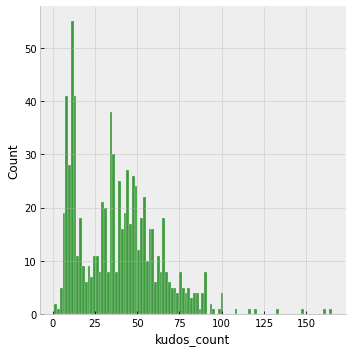

In [12]:
plot_dist(data_outliers_removed, 'kudos_count')

count    7.870000e+02
mean     2.188000e-16
std      1.000636e+00
min     -2.585208e+00
25%     -9.950495e-01
50%      1.358669e-01
75%      7.121422e-01
max      3.163536e+00
Name: target_boxcox, dtype: float64


/home/jack/miniconda3/envs/pycaret/lib/python3.9/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


<Figure size 648x576 with 0 Axes>

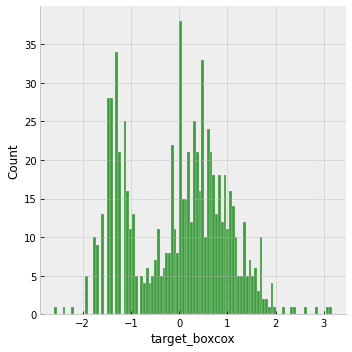

In [13]:
pt = PowerTransformer()
data_outliers_removed.loc[:, 'target_boxcox'] = pt.fit_transform(data_outliers_removed[['kudos_count']])
plot_dist(data_outliers_removed, 'target_boxcox')

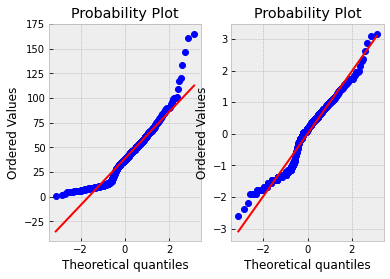

In [14]:
# pp-plots
plt.subplot(1, 2, 1)
res1 = stats.probplot(data_outliers_removed['kudos_count'], plot=plt)
plt.subplot(1, 2, 2)
res = stats.probplot(data_outliers_removed['target_boxcox'], plot=plt)
plt.show()

# Numerical data distribution

## Distributions

In [15]:
data_num = data[numeric_cols]
data_num.head()

,distance,moving_time,total_elevation_gain,max_speed,average_heartrate,max_heartrate,pr_count,total_photo_count,suffer_score,run_area,average_speed_mpk,kudos_count
287,10.4163,45.566667,18.0,5.0,130.3,149.0,0,0,10.0,5.428935,4.374278,29
288,16.1663,70.250000,20.0,5.3,141.9,158.0,3,0,25.0,16.859057,4.345763,36
289,1.6812,8.166667,8.0,5.7,139.2,150.0,0,0,2.0,0.017541,4.857476,14
290,12.8514,42.183333,21.0,6.5,146.3,191.0,0,0,24.0,0.535336,3.282001,56
291,3.3194,15.300000,3.0,6.9,113.3,126.0,0,0,2.0,0.008149,4.608960,8


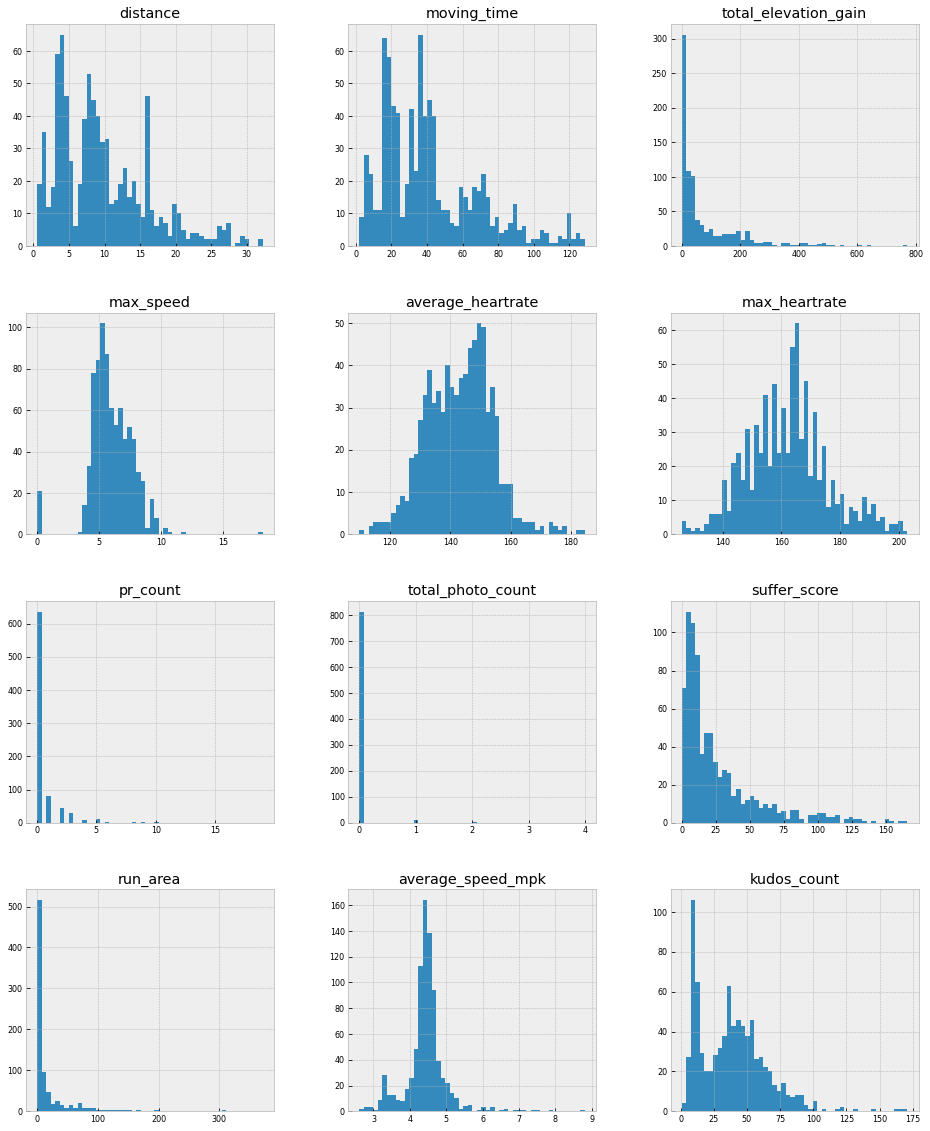

In [16]:
data_num.hist(figsize=(16, 20), bins=50, xlabelsize=8, ylabelsize=8);

Features such as `distance`, `moving_time`, `average_speed_mpk`, ... seems to share a similar distribution to the one we have with `kudos_count`. Lets see if we can find new clues later.
* photo count only has single value - needs to be dropped

In [17]:
col_to_drop = []
col_to_drop.append('photo_count')

## Correlation

Now we'll try to find which features are strongly correlated with `kudos_count`. We'll store them in a var called `golden_features_list`. We'll reuse our df_num dataset to do so.

In [18]:
data_num_corr = data_num.corr()['kudos_count'][:-1] # -1 because the latest row is kudos_count
golden_features_list = data_num_corr[abs(data_num_corr) > 0.5].sort_values(ascending=False)
print(f"There is {len(golden_features_list)} strongly correlated values with kudos count:\n{golden_features_list}")

There is 6 strongly correlated values with kudos count:
distance                0.743850
moving_time             0.690125
suffer_score            0.676383
max_heartrate           0.538556
total_elevation_gain    0.505623
average_speed_mpk      -0.504010
Name: kudos_count, dtype: float64


Perfect, we now have a list of strongly correlated values but this list is incomplete as we know that correlation is affected by outliers. So we could proceed as follow:

* Plot the numerical features and see which ones have very few or explainable outliers
* Remove the outliers from these features and see which one can have a good correlation without their outliers

Also, correlation by itself does not always explain the relationship between data so ploting them could even lead us to new insights and in the same manner, check that our correlated values have a linear relationship to the `kudos_count`.

For example, relationships such as non-linear relationship cannot be guessed just by looking at the correlation value so lets take the features we excluded from our correlation table and plot them to see if they show some kind of pattern.

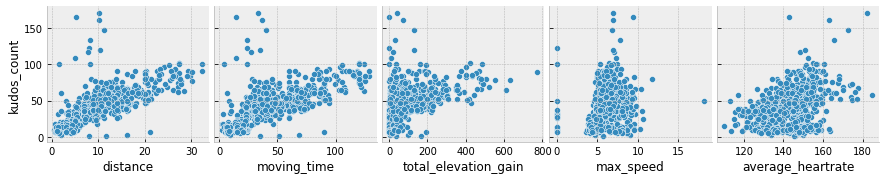

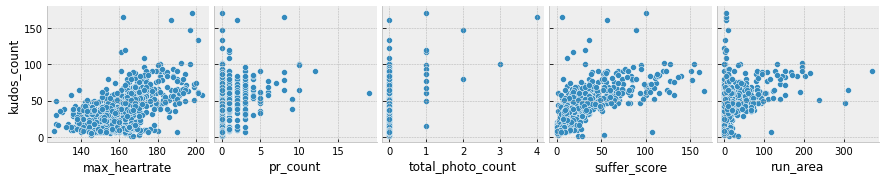

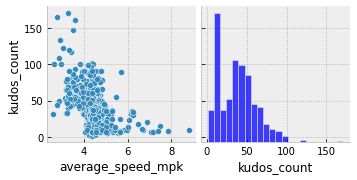

In [19]:
for i in range(0, len(data_num.columns), 5):
    sns.pairplot(data=data_num,
                x_vars=data_num.columns[i:i+5],
                y_vars=['kudos_count'])

We can clearly identify some relationships. Most of them seems to have a linear relationship with the kudos_count and if we look closely at the data we can see that a lot of data points are located on x = 0 which may indicate the run was not available to the public. 
* Maybe make total_photo_count binary feature and target encode

In [20]:
import operator
individual_features_df = []
for i in range(0, len(data_num.columns) - 1): # -1 because the last column is SalePrice
    tmpDf = data_num[[data_num.columns[i], 'kudos_count']]
    tmpDf = tmpDf[tmpDf[data_num.columns[i]] != 0]
    individual_features_df.append(tmpDf)

all_correlations = {feature.columns[0]: feature.corr()['kudos_count'][0] for feature in individual_features_df}
all_correlations = sorted(all_correlations.items(), key=operator.itemgetter(1))
for (key, value) in all_correlations:
    print("{:>15}: {:>15}".format(key, value))

average_speed_mpk: -0.5040099052443349
      max_speed: 0.28361720923447303
       pr_count: 0.29276939025644044
average_heartrate: 0.3976267833119582
       run_area: 0.4074981976344009
total_photo_count: 0.451948955001544
total_elevation_gain: 0.5096620208899963
  max_heartrate: 0.5385557104776938
   suffer_score: 0.6752623631955145
    moving_time: 0.6901252867301206
       distance: 0.743849682179682


In [21]:
golden_features_list = [key for key, value in all_correlations if abs(value) >= 0.49]
print(f"There is {len(golden_features_list)} strongly correlated values with SalePrice:\n{golden_features_list}")

There is 6 strongly correlated values with SalePrice:
['average_speed_mpk', 'total_elevation_gain', 'max_heartrate', 'suffer_score', 'moving_time', 'distance']


We found strongly correlated predictors with `kudos_count`. Later with feature engineering we may add dummy values where value of a given feature > 0 would be 1 (precense of such feature) and 0 would be 0.
For `total_photo_count` for example, we could create a dummy value for its precense or non-precense. Same with `pr_count`, we can bin it into 3 or more PRs. 

## Conclusion

`By looking at correlation between numerical values we discovered 6 features which have a strong relationship to kudos count. Besides correlation we didn't find any notable pattern on the datas which are not correlated.`



# Feature to feature relationship

Trying to plot all the numerical features in a seaborn pairplot will take us too much time and will be hard to interpret. We can try to see if some variables are linked between each other and then explain their relation with common sense.

<AxesSubplot:>

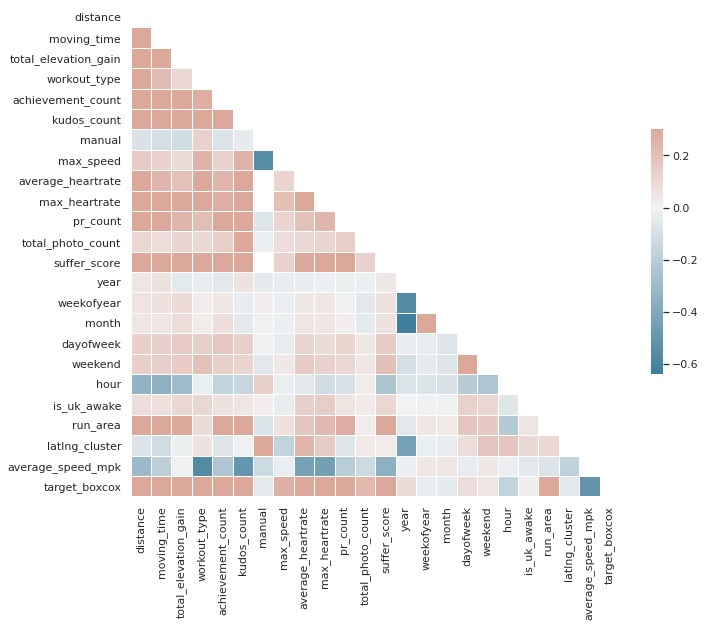

In [22]:
sns.set_theme(style="white")
# Compute the correlation matrix
corr = data.corr()
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))
# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

A lot of features seems to be correlated between each other. Some of them are as expected though: distance/moving time, distance/elevation etc.

Now for the ones which are less obvious we can see that:

Strong positive cor. with moving time and hour of the day indicates my run schedule is fairly rigid.

`May need to perform some PCA as a lot of features are correlated`

In [23]:
col_to_drop.append('athlete_count')

# Q -> Q (Quantitative to Quantitative relationship)

Let's now examine the quantitative features of our dataframe and how they relate to the kudos_count which is also quantitative (hence the relation Q -> Q). 

In [24]:
data_cat = data[cat_cols]
data_cat.head()

,workout_type,timezone,manual,year,weekofyear,month,dayofweek,weekend,hour,is_uk_awake,latlng_cluster,city
287,0.0,America/Boise,False,2021,11,3,2,0,15,1,1,Boise
288,0.0,America/Boise,False,2021,11,3,2,0,8,1,1,Boise
289,0.0,America/Boise,False,2021,11,3,1,0,15,1,1,Boise
290,3.0,America/Boise,False,2021,11,3,1,0,14,1,1,Boise
291,0.0,America/Boise,False,2021,11,3,1,0,14,1,1,Boise


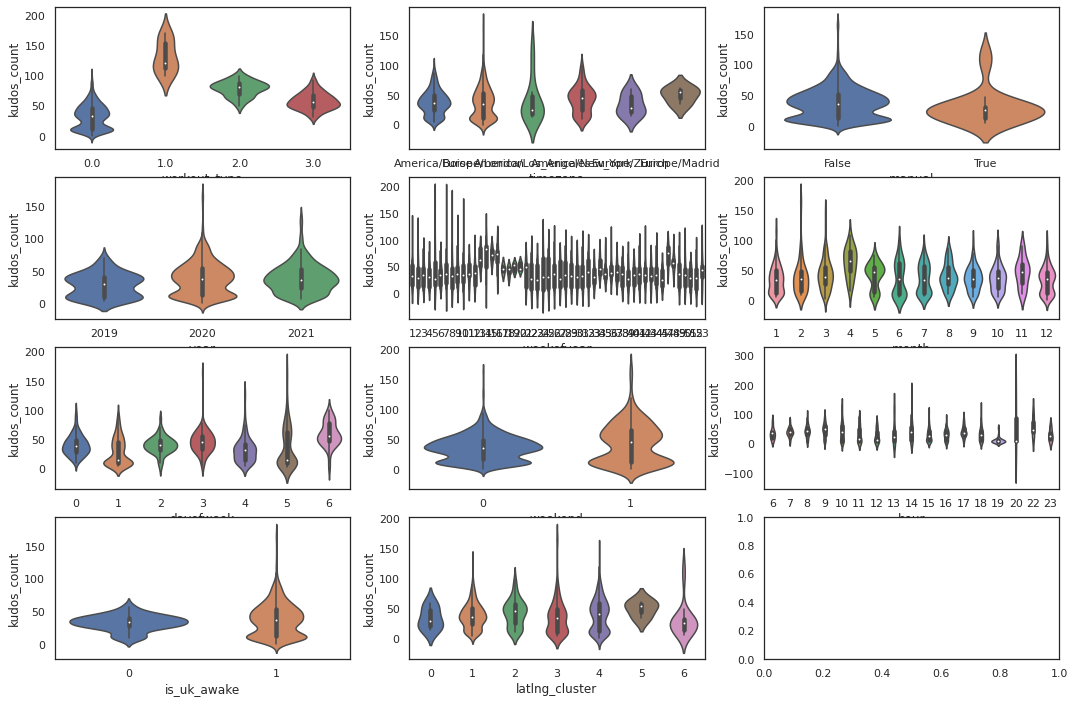

In [25]:
fig, ax = plt.subplots(round(len(cat_cols) / 3), 3, figsize = (18, 12))

for i, ax in enumerate(fig.axes):
    if i < len(cat_cols) - 1:
        sns.violinplot(data = data, x=cat_cols[i], y='kudos_count', ax=ax)


/tmp/ipykernel_4911/2408284898.py:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.xaxis.get_majorticklabels(), rotation=45)
/tmp/ipykernel_4911/2408284898.py:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.xaxis.get_majorticklabels(), rotation=45)
/tmp/ipykernel_4911/2408284898.py:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.xaxis.get_majorticklabels(), rotation=45)
/tmp/ipykernel_4911/2408284898.py:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.xaxis.get_majorticklabels(), rotation=45)
/tmp/ipykernel_4911/2408284898.py:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.xaxis.get_majorticklabels(), rotation=45)
/tmp/ipykernel_4911/2408284898.py:5: UserWarning: FixedFormatter should only be used together with FixedLocato

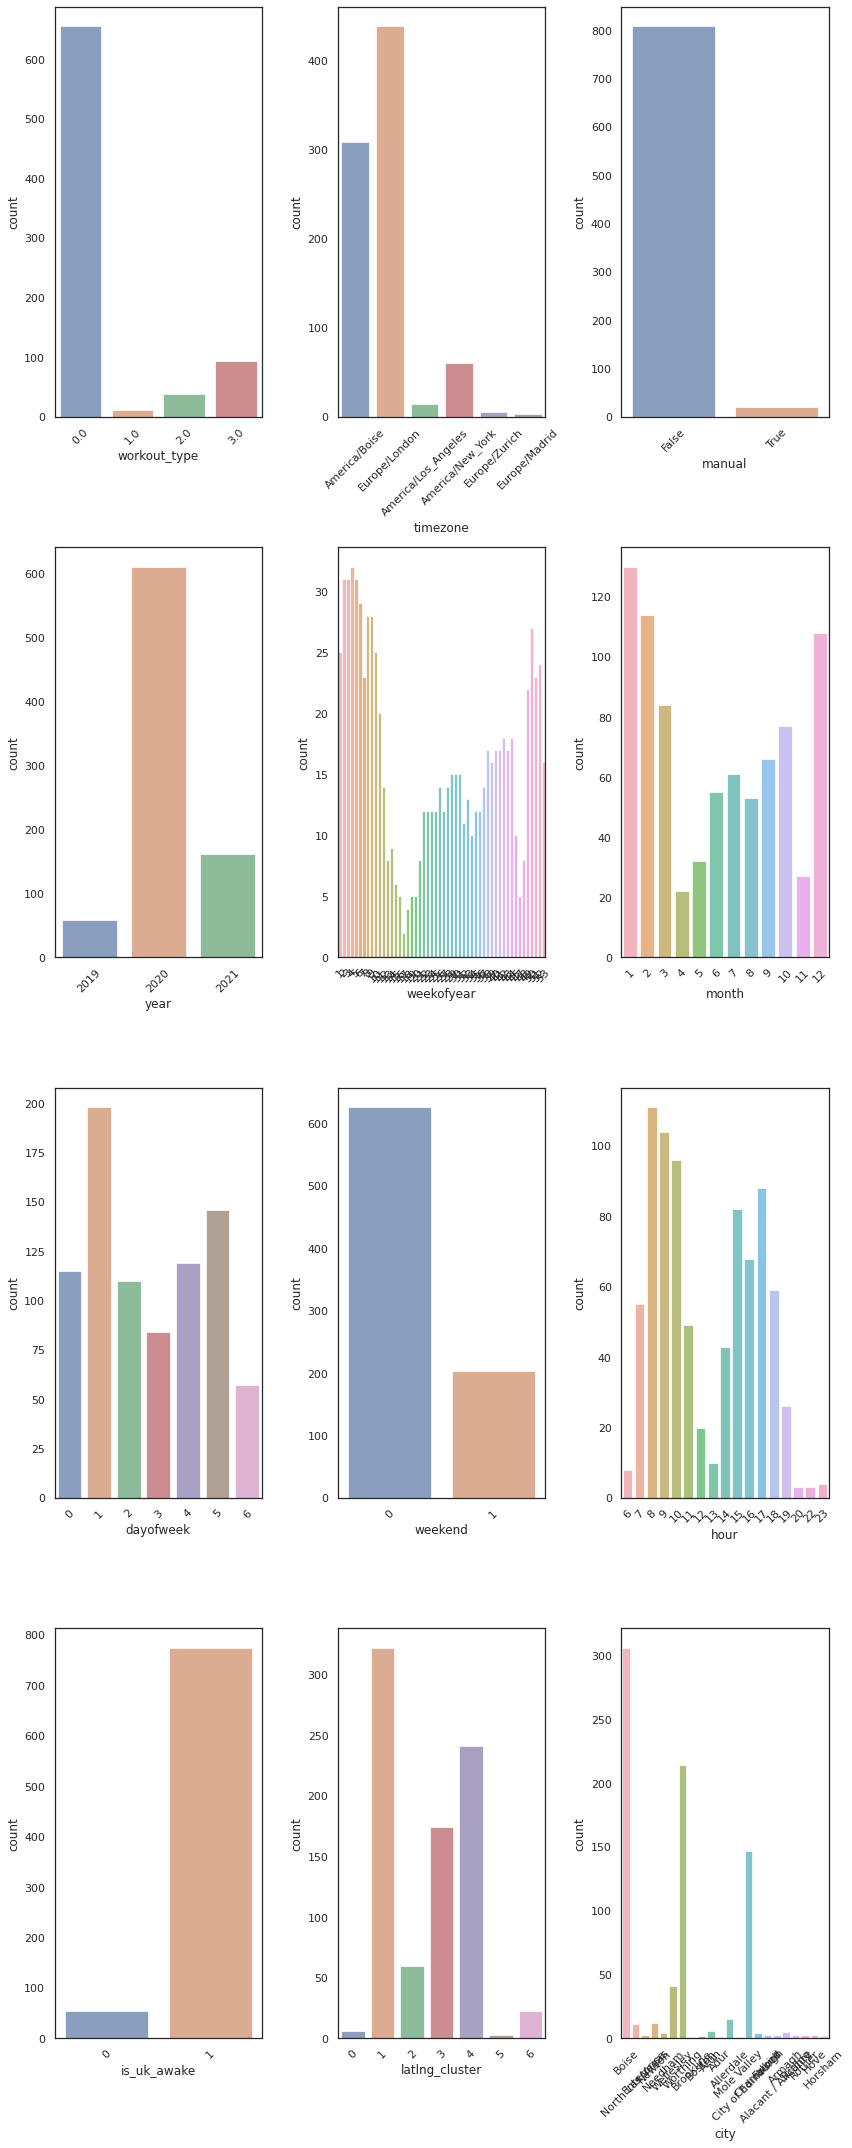

In [26]:
fig, axes = plt.subplots(round(len(cat_cols) / 3), 3, figsize=(12, 30))

for i, ax in enumerate(fig.axes):
    if i < len(cat_cols):
        ax.set_xticklabels(ax.xaxis.get_majorticklabels(), rotation=45)
        sns.countplot(x=cat_cols[i], alpha=0.7, data=data, ax=ax)

fig.tight_layout()

In [27]:
print(col_to_drop)

['photo_count', 'athlete_count']
